In [8]:
!pip install kaggle

In [19]:
!cp kaggle.json ~/.kaggle/

In [20]:
!chmod 600 /root/.kaggle/kaggle.json

In [21]:
!kaggle competitions download -c learn-ai-bbc

  0% 0.00/1.85M [00:00<?, ?B/s]
100% 1.85M/1.85M [00:00<00:00, 128MB/s]


In [22]:
!mkdir data

mkdir: cannot create directory ‘data’: File exists


In [23]:
!unzip ./learn-ai-bbc.zip -d data/

Archive:  ./learn-ai-bbc.zip
  inflating: data/BBC News Sample Solution.csv  
  inflating: data/BBC News Test.csv  
  inflating: data/BBC News Train.csv  


In [24]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## **EDA**

### Importing and Reading the Data

In [25]:
prePath = './data'
sample_solutionPath = os.path.join(prePath,'BBC News Sample Solution.csv')
trainDataPath = os.path.join(prePath,'BBC News Train.csv')
testDataPath = os.path.join(prePath,'BBC News Test.csv')

Sample Solution Table Describe the format that have to follow to submit.

In [26]:
sampleSolutionData = pd.read_csv(sample_solutionPath)
sampleSolutionData.head()

,ArticleId,Category
0,1018,sport
1,1319,tech
2,1138,business
3,459,entertainment
4,1020,politics


### Train DataSet

Train Dataset contains the ArticleID and Text and Category Columns.

Category is the dependent variable that our model need to predict using the independent variables such as AricleID and Text from the Test DataSet.

In [27]:
trainData = pd.read_csv(trainDataPath)
trainData.head()

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


ArticleID Column doesn't contains any duplicate Id values.

In [28]:
duplicate_rows = trainData[trainData.duplicated(subset=['ArticleId'], keep=False)]
print(duplicate_rows)


Empty DataFrame
Columns: [ArticleId, Text, Category]
Index: []


DataSet has 1490 rows and 3 columns.

In [29]:
trainData.shape

(1490, 3)

In [30]:
print(f'Total Number of Null Values Contained in the Dataset:')
print(trainData.isnull().sum())


Total Number of Null Values Contained in the Dataset:
ArticleId    0
Text         0
Category     0
dtype: int64


Accroding the output of following cell indicate ArticleId Feature Column has

In [31]:
trainData['ArticleId'].nunique()

1490

In Train Dataset, ArticleId Features datatype is 64 bits integer and Text and Category Feature Columns are Object Types.

In [32]:
trainData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.0+ KB


Here is the Category Labels present in the DataSet. There are total of 5 different kinds of Category Labels

In [33]:
print(trainData["Category"].unique())
print("Total Number of Categories: ",len(trainData["Category"].unique()))

['business' 'tech' 'politics' 'sport' 'entertainment']
Total Number of Categories:  5


### Test DataSet

Test Dataset contains the ArticleId and Text Columns.

In [34]:
testData = pd.read_csv(testDataPath)
testData.head()

,ArticleId,Text
0,1018,qpr keeper day heads for preston queens park r...
1,1319,software watching while you work software that...
2,1138,d arcy injury adds to ireland woe gordon d arc...
3,459,india s reliance family feud heats up the ongo...
4,1020,boro suffer morrison injury blow middlesbrough...


TestDataSet also doen't has null values.

In [35]:
print(f'Total Number of Null Values Contained in the Dataset:')
print(testData.isnull().sum())


Total Number of Null Values Contained in the Dataset:
ArticleId    0
Text         0
dtype: int64


## Data Distributation

Here is the data distribuation of the Category Values in the Train DataSet

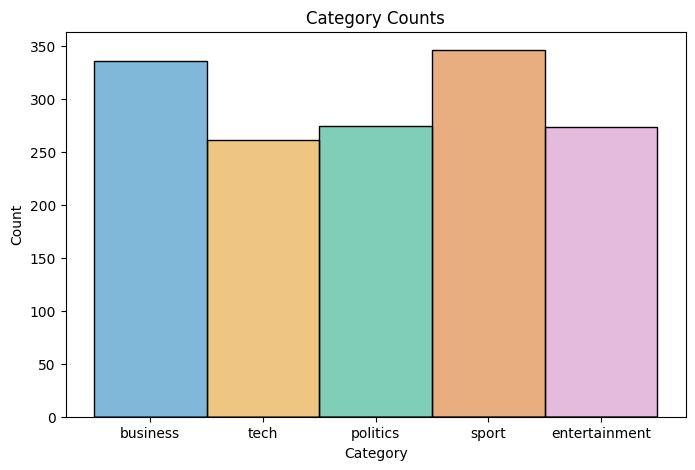

In [36]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.histplot(
    data = trainData,
    x = 'Category',
    hue = 'Category',
    palette = 'colorblind',
    legend = False,
    ).set(
        title = 'Category Counts');

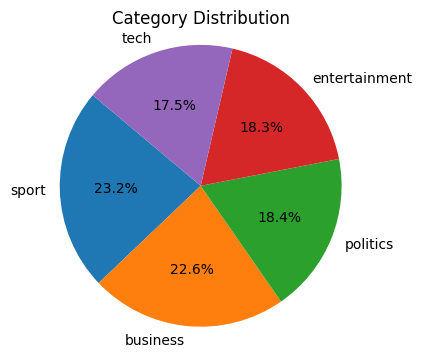

In [37]:
# Calculate category counts
category_counts = trainData['Category'].value_counts()

# Create a pie chart
plt.figure(figsize=(4, 4))
plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', startangle=140,)
plt.title('Category Distribution')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

Sport Value contribute most and tech contribute least the Category Column.All the values' contributation amount more or less similiary to each other.

Now let's inspect the text of trainData' first column.

In [38]:
trainData['Text'][0]

'worldcom ex-boss launches defence lawyers defending former worldcom chief bernie ebbers against a battery of fraud charges have called a company whistleblower as their first witness.  cynthia cooper  worldcom s ex-head of internal accounting  alerted directors to irregular accounting practices at the us telecoms giant in 2002. her warnings led to the collapse of the firm following the discovery of an $11bn (£5.7bn) accounting fraud. mr ebbers has pleaded not guilty to charges of fraud and conspiracy.  prosecution lawyers have argued that mr ebbers orchestrated a series of accounting tricks at worldcom  ordering employees to hide expenses and inflate revenues to meet wall street earnings estimates. but ms cooper  who now runs her own consulting business  told a jury in new york on wednesday that external auditors arthur andersen had approved worldcom s accounting in early 2001 and 2002. she said andersen had given a  green light  to the procedures and practices used by worldcom. mr ebb

According the outputed text data, we can assume that the text has already processed a bit.Capitalization and spelling are two important factors when it comes to natural language processing. But the text still need to do processing such as
stemming, lemmatization and  removing of stopwords, punctuations and unicode characters such as emojis in advance.


In [39]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [40]:
import pandas as pd
import re
import spacy
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# Load English language model in spaCy
nlp = spacy.load("en_core_web_sm")

# Define stopwords
stop_words = set(stopwords.words('english'))

# Define stemmer
stemmer = PorterStemmer()

def clean_text(text):
    # Remove Unicode characters and emojis
    cleaned_text = text.encode('ascii', 'ignore').decode('ascii')

    # Tokenize text using spaCy for lemmatization
    doc = nlp(cleaned_text)

    # Lemmatization
    lemmatized_text = ' '.join([token.lemma_ for token in doc])

    # Remove stopwords and perform stemming
    cleaned_words = [stemmer.stem(word) for word in lemmatized_text.split() if word.lower() not in stop_words]

    # Remove punctuation
    cleaned_text = re.sub(r'[^\w\s]', '', ' '.join(cleaned_words))

    return cleaned_text

# Example usage:
# Assuming df is your DataFrame with a 'Text' column


In [41]:
trainData['Cleaned_Text'] = trainData['Text'].apply(clean_text)

In [42]:
trainData['Cleaned_Text'][0]

'worldcom ex  boss launch defenc lawyer defend former worldcom chief berni ebber batteri fraud charg call compani whistleblow first wit  cynthia cooper worldcom ex  head intern account alert director irregular account practic us telecom giant 2002  warn lead collaps firm follow discoveri  11bn  57bn  account fraud  mr ebber plead guilti charg fraud conspiraci  prosecut lawyer argu mr ebber orchestr seri account trick worldcom order employe hide expens inflat revenu meet wall street earn estim  ms cooper run consult busi tell juri new york wednesday extern auditor arthur andersen approv worldcom account earli 2001 2002  say andersen give green light procedur practic use worldcom  mr ebber lawyer say unawar fraud argu auditor alert problem  ms cooper also say sharehold meet mr ebber often pass technic question compani financ chief give brief answer  prosecut star wit former worldcom financi chief scott sullivan say mr ebber order account adjust firm tell hit book  howev ms cooper say mr 

In [43]:
trainData['num_words'] = trainData['Cleaned_Text'].apply(lambda lst: len(lst))

World Statstic



After cleaning, we can see (below) the number of words per article. We see most articles are around 2000 words. However, we also see we have some severe outliers that reach up to more than 7500 words! We actually will remove these outliers as they might actually impact our model later on, in addition to creating more
features (words) to have to calculate within the model.


<ipython-input-44-80bcf7995cca>:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(


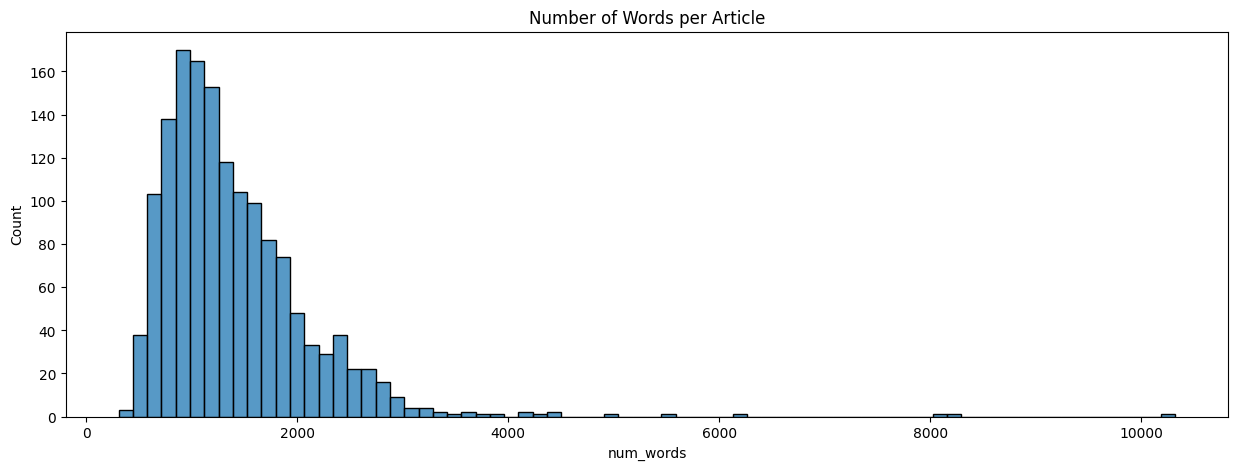

In [44]:
# number of tokens (words) per article
fig, ax = plt.subplots(figsize=(15, 5))
sns.histplot(
    data = trainData,
    x = 'num_words',
    palette = 'colorblind',
    ).set(
        title = 'Number of Words per Article');

So let's remove the outliner otherwise it could impact the model performance.

In [45]:


#remove outlier articles (longer than 6200 words)
trainData = trainData[trainData['num_words'] < 6200]
len(trainData)



1487

Here is the output of words per category

<ipython-input-46-b9e715fae9a6>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


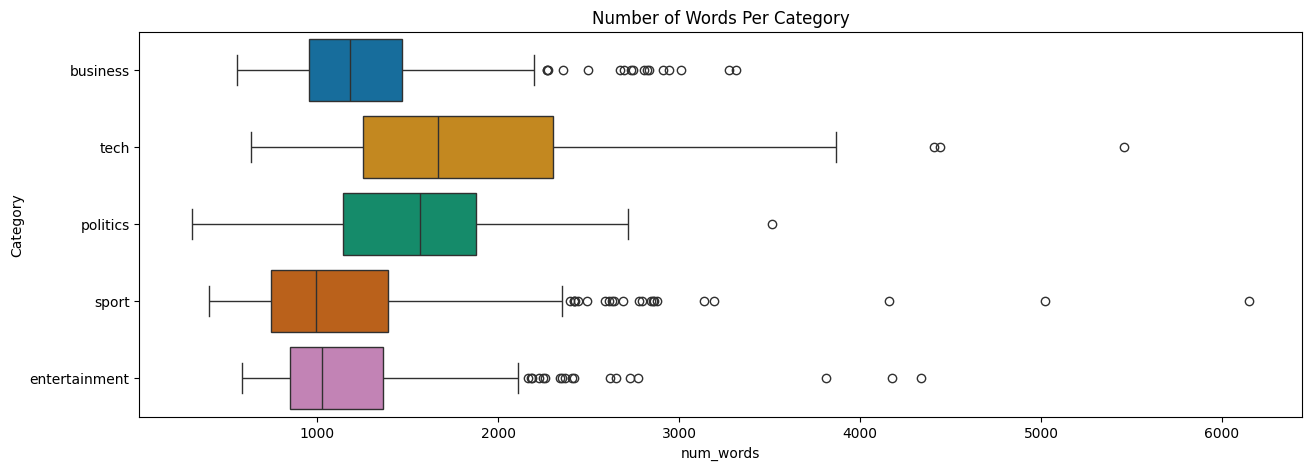

In [46]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(
    data = trainData,
    x = 'num_words',
    y = 'Category',
    palette = 'colorblind'
    ).set(
        title = 'Number of Words Per Category');

## Model Building

In [47]:
train_df = trainData.copy()

In [48]:
def predict(w_matrix):
    sortedW = np.argsort(w_matrix)
    n_predictions, maxValue = sortedW.shape
    predictions = [[sortedW[i][maxValue - 1]] for i in range(n_predictions)]
    topics = np.empty(n_predictions, dtype = np.int64)
    for i in range(n_predictions):
        topics[i] = predictions[i][0]
    return topics

In [49]:
from sklearn.metrics import confusion_matrix
def label_permute(ytdf,yp,n=5):
    """
    ytdf: labels dataframe object
    yp: clustering label prediction output
    Returns permuted label order and accuracy.
    Example output: (3, 4, 1, 2, 0), 0.74
    """
    perms = list(itertools.permutations([0, 1, 2, 3, 4]))    #create permutation list
    best_labels = []
    best_acc = 0
    current = {}
    labels = ['business', 'tech', 'politics', 'sport', 'entertainment']
    for perm in perms:
        for i in range(n):
            current[labels[i]] = perm[i]
            if len(current) == 5:
                conditions = [
                    (ytdf['Category'] == current['business']),
                    (ytdf['Category'] == current['tech']),
                    (ytdf['Category'] == current['politics']),
                    (ytdf['Category'] == current['sport']),
                    (ytdf['Category'] == current['entertainment'])]
                ytdf['test'] = ytdf['Category'].map(current)
                current_accuracy = accuracy_score(ytdf['test'], yp)
                if current_accuracy > best_acc:
                    best_acc = current_accuracy
                    best_labels = perm
                    ytdf['best'] = ytdf['test']
    cm = confusion_matrix(ytdf['best'], yp)
    print(f'confusion_matrix\n')
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', )
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()
    return best_labels, best_acc

### **Natural Language Processing (NLP)**



NLP is a field of artificial intelligence that focuses on the interaction between computers and humans through natural language. Words are the fundamental units of language, and NLP tasks often involve processing and understanding these words in various ways. Here's a brief overview of how NLP works with words:

**Tokenization**:

Tokenization is the process of breaking down a text into individual words or tokens. This step is crucial for further analysis because it provides the basic units for processing.
For example, the sentence "The quick brown fox jumps over the lazy dog" would be tokenized into ["The", "quick", "brown", "fox", "jumps", "over", "the", "lazy", "dog"].

**Normalization**:

Normalization involves converting words to a standard format to ensure consistency. This may include converting all words to lowercase, removing punctuation marks, and handling special characters.
For example, "HELLO" and "hello" would be normalized to "hello".

**Stopword Removal**:

Stopwords are common words that often do not carry much meaning in a text, such as "the", "is", "and", etc. In many NLP tasks, stopwords are removed to focus on more meaningful words.
For example, "The quick brown fox" might have "the" removed, leaving "quick brown fox".
Stemming and Lemmatization:

Stemming and lemmatization are techniques used to reduce words to their base or root form.
Stemming removes suffixes from words to obtain their root form. For example, "running" and "runs" would both be stemmed to "run".
Lemmatization, on the other hand, reduces words to their canonical form (lemma) based on their dictionary definition. For example, "am", "are", and "is" would all be lemmatized to "be".

**Word Embeddings**:

Word embeddings represent words as dense vectors in a continuous vector space. These vectors capture semantic relationships between words based on their usage in context.
Techniques like Word2Vec, GloVe, and FastText are commonly used to generate word embeddings.

**Semantic Analysis**:

NLP tasks often involve analyzing the meaning of words in context. This may include sentiment analysis, named entity recognition, part-of-speech tagging, and syntactic parsing.
In summary, NLP works with words by processing and understanding them in various ways, from basic tokenization and normalization to more advanced techniques like word embeddings and semantic analysis. These techniques enable computers to analyze, understand, and generate human language text.


**Vectorization:**

TfidfVectorizer converts the raw text documents into a matrix representation, where each row corresponds to a document and each column corresponds to a term (word).
The value in each cell of the matrix represents the TF-IDF score of the corresponding term in the corresponding document.
Normalization:


***TfidfVectorizer*** is to convert a collection of raw documents into a matrix of TF-IDF features. TF-IDF stands for Term Frequency-Inverse Document Frequency. It is a statistical measure used to evaluate the importance of a word in a document relative to a collection of documents (corpus).


**TF-IDF Weighting:**

TF-IDF is calculated by multiplying the TF of a term by the IDF of the term. The resulting TF-IDF score reflects the importance of a term within a document relative to the entire corpus.
TfidfVectorizer calculates the TF-IDF score for each term in each document.


TfidfVectorizer optionally normalizes the TF-IDF matrix to have unit norm, which can improve the performance of machine learning algorithms that require normalized input data.

**TF-IDF Calculation**:

The TF-IDF score for a word in a document is calculated by multiplying its Term Frequency (TF) by its Inverse Document Frequency (IDF). The formula is as follows:

TF-IDF(t,d,D) = TF(t,d) x IDF(t,D)

where
TF(t,d) is the Term Frequency of word t in document d.
IDF(t,D) is the Inverse Document Frequency of word t in the corpus D.

**Application in Word Embedding**:
TF-IDF can be used to convert text documents into numerical vectors, also known as word embeddings. Each word in the vocabulary is assigned a unique TF-IDF score based on its importance in individual documents and across the entire corpus. These TF-IDF scores serve as features for machine learning models in tasks such as classification, clustering, or information retrieval.

confusion_matrix



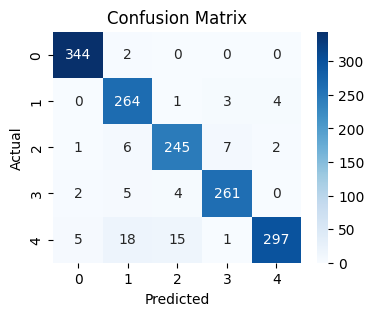

accuracy= 0.948890383322125


In [50]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidvec = TfidfVectorizer(min_df = 2,
                          max_df = 0.95,
                          norm = 'l2',
                          stop_words = 'english')
tfidvec_train = tfidvec.fit_transform(train_df['Cleaned_Text'])

from sklearn.decomposition import NMF
import itertools
from sklearn.metrics import accuracy_score

#create model
nmf_model = NMF(n_components=5,
                init='nndsvda',
                solver = 'mu',
                beta_loss = 'kullback-leibler',
                l1_ratio = 0.5,
                random_state = 101)
nmf_model.fit(tfidvec_train)

#view results
yhat_train = predict(nmf_model.transform(tfidvec_train))
label_order, accuracy = label_permute(train_df, yhat_train )
print('accuracy=', accuracy)

### Tuning Hyperparameters

confusion_matrix



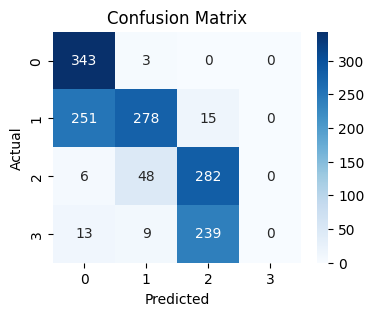

accuracy= 0.6072629455279085
confusion_matrix



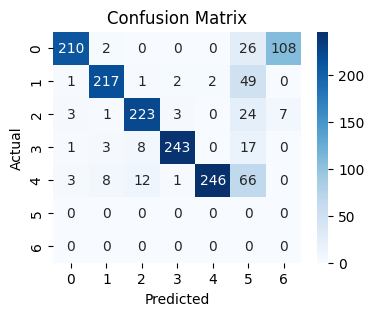

accuracy= 0.7659717552118359


In [51]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidvec = TfidfVectorizer(min_df = 2,
                          max_df = 0.95,
                          norm = 'l2',
                          stop_words = 'english')
tfidvec_train = tfidvec.fit_transform(train_df['Cleaned_Text'])
from sklearn.decomposition import NMF
import itertools
from sklearn.metrics import accuracy_score

#create model
nmf_model2 = NMF(n_components=3,
                init='nndsvda',
                solver = 'mu',
                beta_loss = 'kullback-leibler',
                l1_ratio = 0.5,
                random_state = 101)
nmf_model2.fit(tfidvec_train)

#view results
yhat_train = predict(nmf_model2.transform(tfidvec_train))
label_order, accuracy = label_permute(train_df, yhat_train )
print('accuracy=', accuracy) ## 0.6072629455279085

from sklearn.feature_extraction.text import TfidfVectorizer
tfidvec = TfidfVectorizer(min_df = 2,
                          max_df = 0.95,
                          norm = 'l2',
                          stop_words = 'english')
tfidvec_train = tfidvec.fit_transform(train_df['Cleaned_Text'])
from sklearn.decomposition import NMF
import itertools
from sklearn.metrics import accuracy_score

#create model
nmf_model2 = NMF(n_components=7,
                init='nndsvda',
                solver = 'mu',
                beta_loss = 'kullback-leibler',
                l1_ratio = 0.5,
                random_state = 101)
nmf_model2.fit(tfidvec_train)

#view results
yhat_train = predict(nmf_model2.transform(tfidvec_train))
label_order, accuracy = label_permute(train_df, yhat_train )
print('accuracy=', accuracy) ## 0.7659717552118359

Chaning the n_components larger or lesser than 5 doesn't increase the accuracy score. So let keep the n_components values as 5.

confusion_matrix



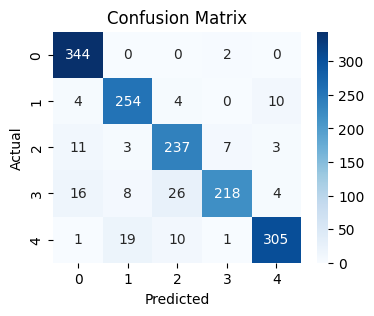

accuracy= 0.9132481506388702


In [52]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidvec = TfidfVectorizer(min_df = 2,
                          max_df = 0.95,
                          norm = 'l2',
                          stop_words = 'english')
tfidvec_train = tfidvec.fit_transform(train_df['Cleaned_Text'])
from sklearn.decomposition import NMF
import itertools
from sklearn.metrics import accuracy_score

#create model
nmf_model2 = NMF(n_components=5,
                init='nndsvda',
                solver = 'mu',
                beta_loss = 'frobenius',
                l1_ratio = 0.5,
                random_state = 101)
nmf_model2.fit(tfidvec_train)

#view results
yhat_train = predict(nmf_model2.transform(tfidvec_train))
label_order, accuracy = label_permute(train_df, yhat_train )
print('accuracy=', accuracy) ## 0.9132481506388702

confusion_matrix



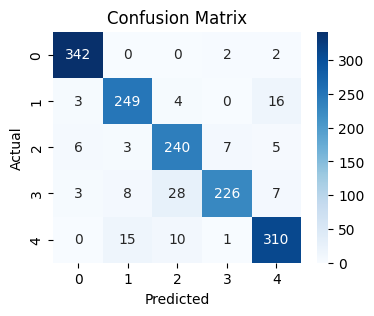

accuracy= 0.9193006052454606


In [53]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidvec = TfidfVectorizer(min_df = 2,
                          max_df = 0.95,
                          norm = 'l2',
                          stop_words = 'english')
tfidvec_train = tfidvec.fit_transform(train_df['Cleaned_Text'])
from sklearn.decomposition import NMF
import itertools
from sklearn.metrics import accuracy_score

#create model
nmf_model2 = NMF(n_components=5,
                init='nndsvda',
                solver = 'cd',
                beta_loss = 'frobenius',
                l1_ratio = 0.5,
                random_state = 101)
nmf_model2.fit(tfidvec_train)

#view results
yhat_train = predict(nmf_model2.transform(tfidvec_train))
label_order, accuracy = label_permute(train_df, yhat_train )
print('accuracy=', accuracy)  ## 0.9193006052454606

Changing the ***beta_loss*** value to ***frobenius*** doesn't increase the value even get lower accuracy score.

Changin teh solver value to ***cd*** also doesn't increase the accuracy score. ***Coordinate Descent (CD)*** work only with ***frobenius***

confusion_matrix



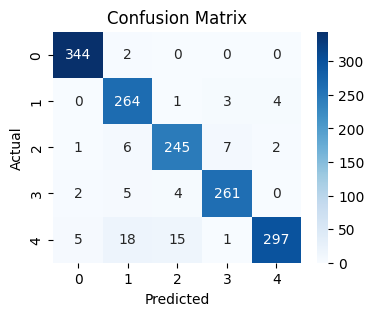

accuracy= 0.948890383322125


In [54]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidvec = TfidfVectorizer(min_df = 2,
                          max_df = 0.95,
                          norm = 'l2',
                          stop_words = 'english')
tfidvec_train = tfidvec.fit_transform(train_df['Cleaned_Text'])
from sklearn.decomposition import NMF
import itertools
from sklearn.metrics import accuracy_score

#create model
nmf_model2 = NMF(n_components=5,
                init='nndsvda',
                solver = 'mu',
                beta_loss = 'kullback-leibler',
                l1_ratio = 0,
                random_state = 101)
nmf_model2.fit(tfidvec_train)

#view results
yhat_train = predict(nmf_model2.transform(tfidvec_train))
label_order, accuracy = label_permute(train_df, yhat_train )
print('accuracy=', accuracy) ## 0.948890383322125

confusion_matrix



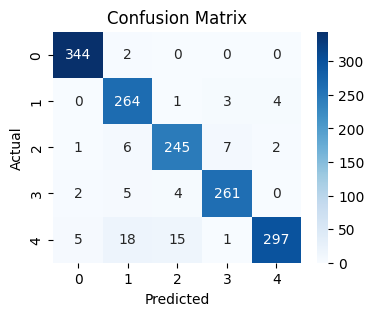

accuracy= 0.948890383322125


In [55]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidvec = TfidfVectorizer(min_df = 2,
                          max_df = 0.95,
                          norm = 'l2',
                          stop_words = 'english')
tfidvec_train = tfidvec.fit_transform(train_df['Cleaned_Text'])
from sklearn.decomposition import NMF
import itertools
from sklearn.metrics import accuracy_score

#create model
nmf_model2 = NMF(n_components=5,
                init='nndsvda',
                solver = 'mu',
                beta_loss = 'kullback-leibler',
                l1_ratio = 1,
                random_state = 101)
nmf_model2.fit(tfidvec_train)

#view results
yhat_train = predict(nmf_model2.transform(tfidvec_train))
label_order, accuracy = label_permute(train_df, yhat_train )
print('accuracy=', accuracy) ## 0.948890383322125

Tuning the ***l1_ratio*** doesn't change the accuracy score.

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1524: UserWarning: The multiplicative update ('mu') solver cannot update zeros present in the initialization, and so leads to poorer results when used jointly with init='nndsvd'. You may try init='nndsvda' or init='nndsvdar' instead.
  warnings.warn(


confusion_matrix



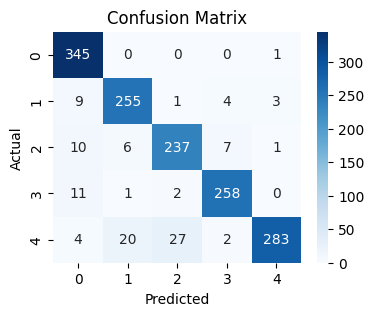

accuracy= 0.9266980497646268


In [56]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidvec = TfidfVectorizer(min_df = 2,
                          max_df = 0.95,
                          norm = 'l2',
                          stop_words = 'english')
tfidvec_train = tfidvec.fit_transform(train_df['Cleaned_Text'])
from sklearn.decomposition import NMF
import itertools
from sklearn.metrics import accuracy_score

#create model
nmf_model2 = NMF(n_components=5,
                init='nndsvd',
                solver = 'mu',
                beta_loss = 'kullback-leibler',
                l1_ratio = 1,
                random_state = 101)
nmf_model2.fit(tfidvec_train)

#view results
yhat_train = predict(nmf_model2.transform(tfidvec_train))
label_order, accuracy = label_permute(train_df, yhat_train )
print('accuracy=', accuracy) ## 0.9266980497646268

confusion_matrix



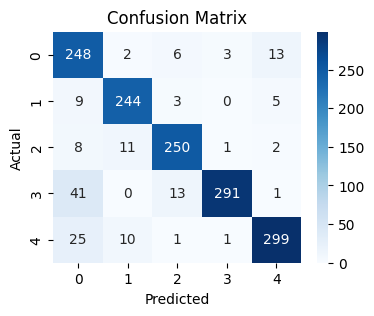

accuracy= 0.8957632817753867


In [57]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidvec = TfidfVectorizer(min_df = 2,
                          max_df = 0.95,
                          norm = 'l2',
                          stop_words = 'english')
tfidvec_train = tfidvec.fit_transform(train_df['Cleaned_Text'])
from sklearn.decomposition import NMF
import itertools
from sklearn.metrics import accuracy_score

#create model
nmf_model2 = NMF(n_components=5,
                init='random',
                solver = 'mu',
                beta_loss = 'kullback-leibler',
                l1_ratio = 1,
                random_state = 101)
nmf_model2.fit(tfidvec_train)

#view results
yhat_train = predict(nmf_model2.transform(tfidvec_train))
label_order, accuracy = label_permute(train_df, yhat_train )
print('accuracy=', accuracy) ## 0.8957632817753867

Tunning the value of ***init*** to ***random*** or ***nndsvd*** doesn't greater more than ***nndsvda***.

confusion_matrix



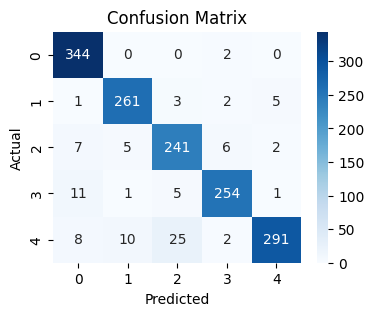

accuracy= 0.9354404841963685


In [58]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidvec = TfidfVectorizer(min_df = 1,
                          max_df = 0.95,
                          norm = 'l2',
                          stop_words = 'english')
tfidvec_train = tfidvec.fit_transform(train_df['Cleaned_Text'])

from sklearn.decomposition import NMF
import itertools
from sklearn.metrics import accuracy_score

#create model
nmf_model = NMF(n_components=5,
                init='nndsvda',
                solver = 'mu',
                beta_loss = 'kullback-leibler',
                l1_ratio = 0.5,
                random_state = 101)
nmf_model.fit(tfidvec_train)

#view results
yhat_train = predict(nmf_model.transform(tfidvec_train))
label_order, accuracy = label_permute(train_df, yhat_train )
print('accuracy=', accuracy) ## 0.9354404841963685

confusion_matrix



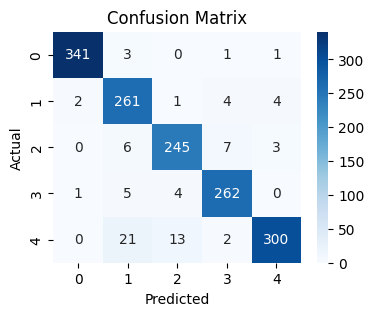

accuracy= 0.9475453934095495


In [59]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidvec = TfidfVectorizer(min_df = 3,
                          max_df = 0.95,
                          norm = 'l2',
                          stop_words = 'english')
tfidvec_train = tfidvec.fit_transform(train_df['Cleaned_Text'])

from sklearn.decomposition import NMF
import itertools
from sklearn.metrics import accuracy_score

#create model
nmf_model = NMF(n_components=5,
                init='nndsvda',
                solver = 'mu',
                beta_loss = 'kullback-leibler',
                l1_ratio = 0.5,
                random_state = 101)
nmf_model.fit(tfidvec_train)

#view results
yhat_train = predict(nmf_model.transform(tfidvec_train))
label_order, accuracy = label_permute(train_df, yhat_train )
print('accuracy=', accuracy)  ## 0.9475453934095495

Tuning the min_df (with 1 and 5 ) from TfidfVectorizer doesn't increase more then previous select value 2. Lower value much better.



confusion_matrix



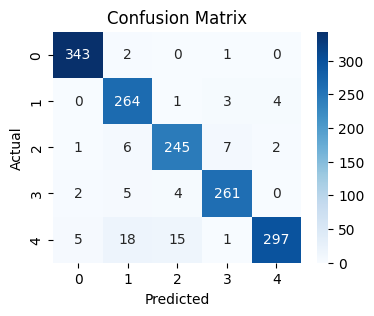

accuracy= 0.9482178883658372


In [60]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidvec = TfidfVectorizer(min_df = 2,
                          max_df = 0.85,
                          norm = 'l2',
                          stop_words = 'english')
tfidvec_train = tfidvec.fit_transform(train_df['Cleaned_Text'])

from sklearn.decomposition import NMF
import itertools
from sklearn.metrics import accuracy_score

#create model
nmf_model = NMF(n_components=5,
                init='nndsvda',
                solver = 'mu',
                beta_loss = 'kullback-leibler',
                l1_ratio = 0.5,
                random_state = 101)
nmf_model.fit(tfidvec_train)

#view results
yhat_train = predict(nmf_model.transform(tfidvec_train))
label_order, accuracy = label_permute(train_df, yhat_train )
print('accuracy=', accuracy)  ## 0.9482178883658372

confusion_matrix



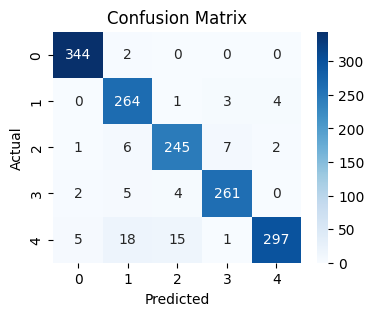

accuracy= 0.948890383322125


In [61]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidvec = TfidfVectorizer(min_df = 2,
                          max_df = 0.99,
                          norm = 'l2',
                          stop_words = 'english')
tfidvec_train = tfidvec.fit_transform(train_df['Cleaned_Text'])

from sklearn.decomposition import NMF
import itertools
from sklearn.metrics import accuracy_score

#create model
nmf_model = NMF(n_components=5,
                init='nndsvda',
                solver = 'mu',
                beta_loss = 'kullback-leibler',
                l1_ratio = 0.5,
                random_state = 101)
nmf_model.fit(tfidvec_train)

#view results
yhat_train = predict(nmf_model.transform(tfidvec_train))
label_order, accuracy = label_permute(train_df, yhat_train )
print('accuracy=', accuracy)  ## 0.948890383322125

Tunning the values of ***max_df*** from TfidfVectorizer doesn't increse the accuracy score. But higher the max_df increase the accuracy score.

confusion_matrix



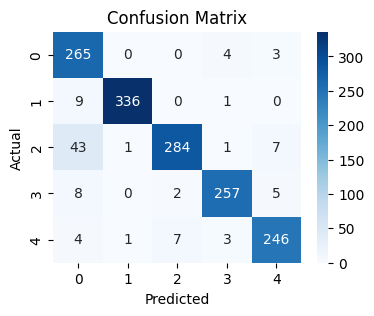

accuracy= 0.933422999327505


In [62]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidvec = TfidfVectorizer(min_df = 2,
                          max_df = 0.90,
                          norm = 'l1',
                          stop_words = 'english')
tfidvec_train = tfidvec.fit_transform(train_df['Cleaned_Text'])

from sklearn.decomposition import NMF
import itertools
from sklearn.metrics import accuracy_score

#create model
nmf_model = NMF(n_components=5,
                init='nndsvda',
                solver = 'mu',
                beta_loss = 'kullback-leibler',
                l1_ratio = 0.5,
                random_state = 101)
nmf_model.fit(tfidvec_train)

#view results
yhat_train = predict(nmf_model.transform(tfidvec_train))
label_order, accuracy = label_permute(train_df, yhat_train )
print('accuracy=', accuracy) ## 0.933422999327505

Select the ***norm*** value to ***l1*** would decrease greatly then selecting to ***l2***.

### Final Model




confusion_matrix



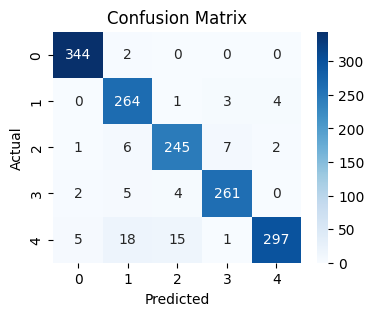

accuracy= 0.948890383322125


In [63]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidvec = TfidfVectorizer(min_df = 2,
                          max_df = 0.95,
                          norm = 'l2',
                          stop_words = 'english')
tfidvec_train = tfidvec.fit_transform(train_df['Cleaned_Text'])

from sklearn.decomposition import NMF
import itertools
from sklearn.metrics import accuracy_score

#create model
nmf_model = NMF(n_components=5,
                init='nndsvda',
                solver = 'mu',
                beta_loss = 'kullback-leibler',
                l1_ratio = 0.5,
                random_state = 101)
nmf_model.fit(tfidvec_train)

#view results
yhat_train = predict(nmf_model.transform(tfidvec_train))
label_order, accuracy = label_permute(train_df, yhat_train )
print('accuracy=', accuracy)

In [64]:
label_order

(4, 2, 1, 0, 3)

In [65]:
#show best labels for the trained model
label_dict = {4:'business', 2:'tech', 1:'politics', 0:'sport', 3:'entertainment'}
for i in range(5):
    print(f'{label_order[i]}:  {label_dict[label_order[i]]}')

4:  business
2:  tech
1:  politics
0:  sport
3:  entertainment


In [66]:
trainData['Category'].unique()

array(['business', 'tech', 'politics', 'sport', 'entertainment'],
      dtype=object)

Let's test on TestDataset

In [67]:
testData['clean_text'] = testData['Text'].apply(clean_text)
tfidvec_test = tfidvec.transform(testData['clean_text'])
yhat_test = predict(nmf_model.transform(tfidvec_test))

Create a submission dataframe

In [68]:
test_predictions = pd.DataFrame(columns=['ArticleId', 'Category', 'yhat'])
test_predictions['ArticleId'] = testData['ArticleId']
test_predictions['yhat'] = yhat_test
test_predictions['Category'] = test_predictions['yhat'].apply(lambda i: label_dict[i])

#delete columns unneeded for submission
test_predictions = test_predictions.drop('yhat', 1)
print(test_predictions.head(15))

    ArticleId       Category
0        1018          sport
1        1319           tech
2        1138          sport
3         459       business
4        1020          sport
5          51          sport
6        2025       politics
7        1479       politics
8          27  entertainment
9         397       business
10       1644       business
11        263           tech
12        765       politics
13       2134           tech
14        297  entertainment


<ipython-input-68-215c8120162e>:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  test_predictions = test_predictions.drop('yhat', 1)


In [69]:
try:
    test_predictions.to_csv('submission.csv', index=False)
except:
    pass

In [70]:
!kaggle competitions submit -c learn-ai-bbc -f submission.csv -m "Unsupervised"

100% 9.17k/9.17k [00:00<00:00, 37.9kB/s]
Successfully submitted to BBC News Classification

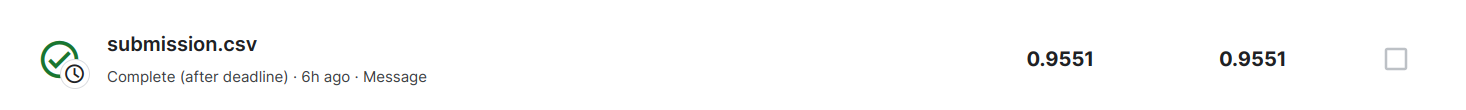

In [71]:
from PIL import Image
unsupervised_img=Image.open('./Kaggle_Completion_Score/Unsupervised_Submission_Score.png',)
unsupervised_img

## Supervised Model

Let's do model comparison with supervised model like K-Means and check is there any improve in model.

### K-Mean

K-Means is a popular unsupervised machine learning algorithm used for clustering data into groups based on similarity. The algorithm works by partitioning the data into K clusters, where each data point belongs to the cluster with the nearest mean (centroid). Here's how K-Means works:

K-Means aims to minimize the within-cluster variance, also known as the inertia or sum of squared distances from each data point to its assigned centroid. The algorithm may converge to a local minimum, and the final clustering depends on the initial random centroids.

K-Means is widely used for various applications, including customer segmentation, image compression, document clustering, and anomaly detection. It is computationally efficient and scales well to large datasets, making it a popular choice for clustering tasks. However, it may struggle with non-linearly separable data or clusters of different shapes and sizes. Alternative clustering algorithms such as DBSCAN or Gaussian Mixture Models may be more suitable for such cases.

In [72]:
train = pd.read_csv(trainDataPath)
test = pd.read_csv(testDataPath)

In [73]:
import re
def clean_text2(dataframe, text_col):
    '''
    A helper function which takes a dataframe
    and removes punction and stopwords.
    '''
    #remove all punctuation
    dataframe['no_punct'] = dataframe[text_col].apply(lambda row: re.sub(r'[^\w\s]+', '', row))

    #remove numbers
    dataframe['no_punct_num'] = dataframe['no_punct'].apply(lambda row: re.sub(r'[0-9]+', '', row))

    #remove stopwords
    stop_words = stopwords.words('english')
    dataframe['no_stopwords'] = dataframe['no_punct_num'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

    #remove extra spaces
    dataframe['clean_text'] = dataframe['no_stopwords'].apply(lambda x: re.sub(' +', ' ', x))
    return

In [74]:
from sklearn.cluster import KMeans
clean_text2(train,'Text')
# train['clean_text'] = train['Text'].apply(clean_text)
# test['clean_text'] = test['Text'].apply(clean_text)

#split data into X and y
y_train = train['Category'].values
X_train = train['clean_text'].values



/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1366: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(


confusion_matrix



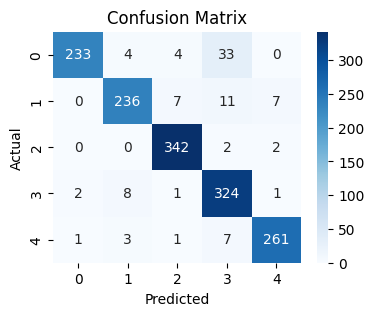

accuracy= 0.9369127516778524
(3, 1, 0, 2, 4) 

3:  business
1:  tech
0:  entertainment
2:  sport
4:  politics


In [75]:
#create new vectorizer for supervised learning model
tfidfvec_supervised = TfidfVectorizer(min_df = 2,
                          max_df = 0.95,
                          norm = 'l2',
                          stop_words = 'english')
tfSuper_train = tfidfvec_supervised.fit_transform(X_train)

#create KMeans Model and train
kmeans = KMeans(n_clusters = 5,
                init = 'k-means++',
                algorithm = 'full',
                random_state = 101)
yhat_train_super = kmeans.fit_predict(tfSuper_train)

#get accuracy
y_train_df = pd.DataFrame(y_train, columns=['Category'])
label_order, accuracy = label_permute(y_train_df, yhat_train_super)
print('accuracy=', accuracy)
print(label_order, '\n')

#show label order
label_dict = {3:'business', 1:'tech', 4:'politics', 2:'sport', 0:'entertainment'}
for i in range(5):
    print(f'{label_order[i]}:  {label_dict[label_order[i]]}')

In [76]:
np.unique(yhat_train_super)

array([0, 1, 2, 3, 4], dtype=int32)

In [77]:
y_train

array(['business', 'business', 'business', ..., 'business', 'tech',
       'tech'], dtype=object)



Now we will test the model on the test set. Again, we need to repeat the same steps to clean the data like we did in the training set.


In [78]:
clean_text2(test,'Text')
X_test = test['clean_text'].values

#create vectorizer (do not fit it!)
tfSuper_test = tfidfvec_supervised.transform(X_test)
yhat_test = kmeans.predict(tfSuper_test)



In [79]:
#create a submission dataframe
test_predictions = pd.DataFrame(columns=['ArticleId', 'Category', 'yhat'])
test_predictions['ArticleId'] = test['ArticleId']
test_predictions['yhat'] = yhat_test
test_predictions['Category'] = test_predictions['yhat'].apply(lambda i: label_dict[i])

#delete columns unneeded for submission
test_predictions = test_predictions.drop('yhat', 1)
print(test_predictions.head(2))

   ArticleId Category
0       1018    sport
1       1319     tech


<ipython-input-79-fddea4b28e10>:8: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  test_predictions = test_predictions.drop('yhat', 1)


In [80]:
#save and submit test dataframe
try:
    test_predictions.to_csv('supervised_submission.csv', index=False)
except:
    pass



In [81]:
!kaggle competitions submit -c learn-ai-bbc -f supervised_submission.csv -m "K-mean model"

100% 9.24k/9.24k [00:00<00:00, 40.8kB/s]
Successfully submitted to BBC News Classification

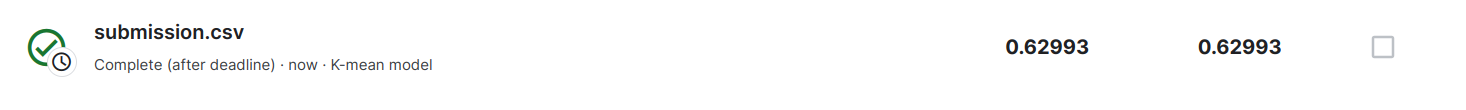

In [82]:
supervised_img=Image.open('./Kaggle_Completion_Score/Supervised_Submission_Score.png',)
supervised_img

Train Accuracy is 0.9369127516778524 and test accuracy is 0.62993 so it is overfitting.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1366: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(


confusion_matrix



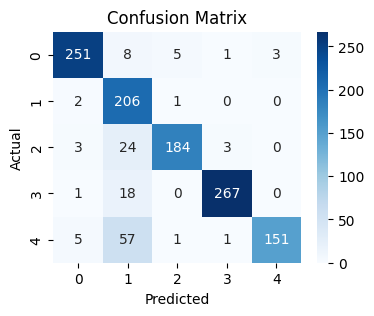

accuracy= 0.8884228187919463
(0, 2, 4, 3, 1) 

0:  entertainment
2:  sport
4:  politics
3:  business
1:  tech
   ArticleId  Category
0       1018  business
1       1319     sport


<ipython-input-83-6657744623e4>:55: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  test_predictions = test_predictions.drop('yhat', 1)


In [83]:
train = pd.read_csv(trainDataPath)
test = pd.read_csv(testDataPath)

import re
from sklearn.cluster import KMeans
clean_text2(train,'Text')
# train['clean_text'] = train['Text'].apply(clean_text)
# test['clean_text'] = test['Text'].apply(clean_text)

#split data into X and y
y_train = train['Category'].values[:-298]
X_train = train['clean_text'].values[:-298]


#create new vectorizer for supervised learning model
tfidfvec_supervised = TfidfVectorizer(min_df = 2,
                          max_df = 0.95,
                          norm = 'l2',
                          stop_words = 'english')
tfSuper_train = tfidfvec_supervised.fit_transform(X_train)

#create KMeans Model and train
kmeans = KMeans(n_clusters = 5,
                init = 'k-means++',
                algorithm = 'full',
                random_state = 101)
yhat_train_super = kmeans.fit_predict(tfSuper_train)

#get accuracy
y_train_df = pd.DataFrame(y_train, columns=['Category'])
label_order, accuracy = label_permute(y_train_df, yhat_train_super)
print('accuracy=', accuracy)
print(label_order, '\n')

#show label order
label_dict = {3:'business', 1:'tech', 4:'politics', 2:'sport', 0:'entertainment'}
for i in range(5):
    print(f'{label_order[i]}:  {label_dict[label_order[i]]}')


clean_text2(test,'Text')
X_test = test['clean_text'].values

#create vectorizer (do not fit it!)
tfSuper_test = tfidfvec_supervised.transform(X_test)
yhat_test = kmeans.predict(tfSuper_test)

#create a submission dataframe
test_predictions = pd.DataFrame(columns=['ArticleId', 'Category', 'yhat'])
test_predictions['ArticleId'] = test['ArticleId']
test_predictions['yhat'] = yhat_test
test_predictions['Category'] = test_predictions['yhat'].apply(lambda i: label_dict[i])

#delete columns unneeded for submission
test_predictions = test_predictions.drop('yhat', 1)
print(test_predictions.head(2))


#save and submit test dataframe
try:
    test_predictions.to_csv('supervised_submission_20.csv', index=False)
except:
    pass

In [84]:
!kaggle competitions submit -c learn-ai-bbc -f supervised_submission_20.csv -m "K-mean model_REDUCED_20%"

100% 9.46k/9.46k [00:00<00:00, 41.7kB/s]
Successfully submitted to BBC News Classification

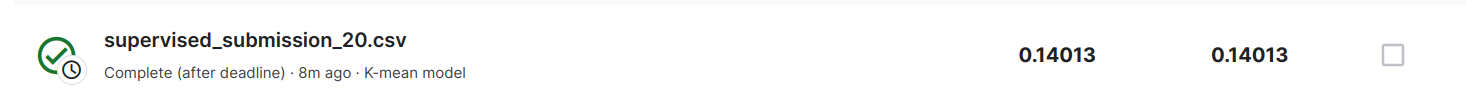

In [85]:
twenty_percent_reduced_img=Image.open('./Kaggle_Completion_Score/supervised_reduceds/K-mean model_REDUCED_20%.png',)
twenty_percent_reduced_img

Reduced 20% of the Training Data

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1366: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(


confusion_matrix



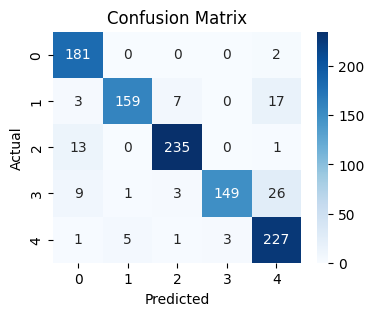

accuracy= 0.9117929050814957
(4, 1, 3, 2, 0) 

4:  politics
1:  tech
3:  business
2:  sport
0:  entertainment
   ArticleId Category
0       1018    sport
1       1319     tech


<ipython-input-86-e364a0dfbeb0>:55: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  test_predictions = test_predictions.drop('yhat', 1)


In [86]:
train = pd.read_csv(trainDataPath)
test = pd.read_csv(testDataPath)

import re
from sklearn.cluster import KMeans
clean_text2(train,'Text')
# train['clean_text'] = train['Text'].apply(clean_text)
# test['clean_text'] = test['Text'].apply(clean_text)

#split data into X and y
y_train = train['Category'].values[:-447]
X_train = train['clean_text'].values[:-447]


#create new vectorizer for supervised learning model
tfidfvec_supervised = TfidfVectorizer(min_df = 2,
                          max_df = 0.95,
                          norm = 'l2',
                          stop_words = 'english')
tfSuper_train = tfidfvec_supervised.fit_transform(X_train)

#create KMeans Model and train
kmeans = KMeans(n_clusters = 5,
                init = 'k-means++',
                algorithm = 'full',
                random_state = 101)
yhat_train_super = kmeans.fit_predict(tfSuper_train)

#get accuracy
y_train_df = pd.DataFrame(y_train, columns=['Category'])
label_order, accuracy = label_permute(y_train_df, yhat_train_super)
print('accuracy=', accuracy)
print(label_order, '\n')

#show label order
label_dict = {3:'business', 1:'tech', 4:'politics', 2:'sport', 0:'entertainment'}
for i in range(5):
    print(f'{label_order[i]}:  {label_dict[label_order[i]]}')


clean_text2(test,'Text')
X_test = test['clean_text'].values

#create vectorizer (do not fit it!)
tfSuper_test = tfidfvec_supervised.transform(X_test)
yhat_test = kmeans.predict(tfSuper_test)

#create a submission dataframe
test_predictions = pd.DataFrame(columns=['ArticleId', 'Category', 'yhat'])
test_predictions['ArticleId'] = test['ArticleId']
test_predictions['yhat'] = yhat_test
test_predictions['Category'] = test_predictions['yhat'].apply(lambda i: label_dict[i])

#delete columns unneeded for submission
test_predictions = test_predictions.drop('yhat', 1)
print(test_predictions.head(2))


#save and submit test dataframe
try:
    test_predictions.to_csv('supervised_submission_30.csv', index=False)
except:
    pass

In [87]:
!kaggle competitions submit -c learn-ai-bbc -f supervised_submission_30.csv -m "K-mean model_REDUCED_30%"

100% 9.34k/9.34k [00:00<00:00, 43.1kB/s]
Successfully submitted to BBC News Classification

Reduced 30% of the Training Data

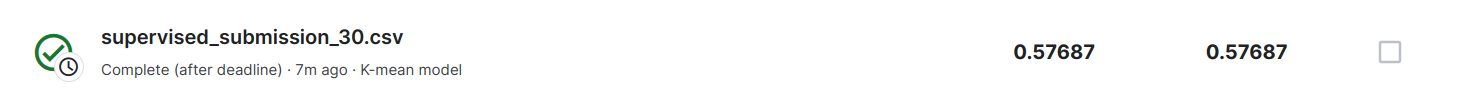

In [88]:
thirty_percent_reduced_img=Image.open('./Kaggle_Completion_Score/supervised_reduceds/K-mean model_REDUCED_30%.png',)
thirty_percent_reduced_img

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1366: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(


confusion_matrix



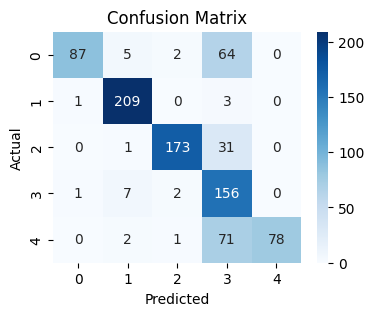

accuracy= 0.7863534675615212
(2, 3, 4, 1, 0) 

2:  sport
3:  business
4:  politics
1:  tech
0:  entertainment
   ArticleId  Category
0       1018      tech
1       1319  business


<ipython-input-89-42932c0bdfe4>:55: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  test_predictions = test_predictions.drop('yhat', 1)


In [89]:
train = pd.read_csv(trainDataPath)
test = pd.read_csv(testDataPath)

import re
from sklearn.cluster import KMeans
clean_text2(train,'Text')
# train['clean_text'] = train['Text'].apply(clean_text)
# test['clean_text'] = test['Text'].apply(clean_text)

#split data into X and y
y_train = train['Category'].values[:-596]
X_train = train['clean_text'].values[:-596]


#create new vectorizer for supervised learning model
tfidfvec_supervised = TfidfVectorizer(min_df = 2,
                          max_df = 0.95,
                          norm = 'l2',
                          stop_words = 'english')
tfSuper_train = tfidfvec_supervised.fit_transform(X_train)

#create KMeans Model and train
kmeans = KMeans(n_clusters = 5,
                init = 'k-means++',
                algorithm = 'full',
                random_state = 101)
yhat_train_super = kmeans.fit_predict(tfSuper_train)

#get accuracy
y_train_df = pd.DataFrame(y_train, columns=['Category'])
label_order, accuracy = label_permute(y_train_df, yhat_train_super)
print('accuracy=', accuracy)
print(label_order, '\n')

#show label order
label_dict = {3:'business', 1:'tech', 4:'politics', 2:'sport', 0:'entertainment'}
for i in range(5):
    print(f'{label_order[i]}:  {label_dict[label_order[i]]}')


clean_text2(test,'Text')
X_test = test['clean_text'].values

#create vectorizer (do not fit it!)
tfSuper_test = tfidfvec_supervised.transform(X_test)
yhat_test = kmeans.predict(tfSuper_test)

#create a submission dataframe
test_predictions = pd.DataFrame(columns=['ArticleId', 'Category', 'yhat'])
test_predictions['ArticleId'] = test['ArticleId']
test_predictions['yhat'] = yhat_test
test_predictions['Category'] = test_predictions['yhat'].apply(lambda i: label_dict[i])

#delete columns unneeded for submission
test_predictions = test_predictions.drop('yhat', 1)
print(test_predictions.head(2))


#save and submit test dataframe
try:
    test_predictions.to_csv('supervised_submission_40.csv', index=False)
except:
    pass

In [90]:
!kaggle competitions submit -c learn-ai-bbc -f supervised_submission_40.csv -m "K-mean model_REDUCED_40%"

100% 8.86k/8.86k [00:00<00:00, 37.9kB/s]
Successfully submitted to BBC News Classification

Reduced 40% of the Training Data

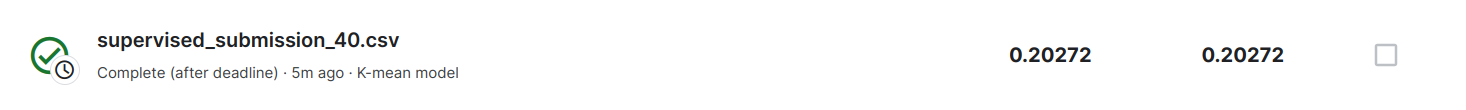

In [91]:
fourty_percent_reduced_img=Image.open('./Kaggle_Completion_Score/supervised_reduceds/K-mean model_REDUCED_40%.png',)
fourty_percent_reduced_img

#Final Model of K-Means

Our first model yeild the highest test score.

In [ ]:
tfidfvec_supervised = TfidfVectorizer(min_df = 2,
                          max_df = 0.95,
                          norm = 'l2',
                          stop_words = 'english')
tfSuper_train = tfidfvec_supervised.fit_transform(X_train)

#create KMeans Model and train
kmeans = KMeans(n_clusters = 5,
                init = 'k-means++',
                algorithm = 'full',
                random_state = 101)
yhat_train_super = kmeans.fit_predict(tfSuper_train)

#get accuracy
y_train_df = pd.DataFrame(y_train, columns=['Category'])
label_order, accuracy = label_permute(y_train_df, yhat_train_super)
print('accuracy=', accuracy)
print(label_order, '\n')

#show label order
label_dict = {3:'business', 1:'tech', 4:'politics', 2:'sport', 0:'entertainment'}
for i in range(5):
    print(f'{label_order[i]}:  {label_dict[label_order[i]]}')

clean_text2(test,'Text')
X_test = test['clean_text'].values

#create vectorizer (do not fit it!)
tfSuper_test = tfidfvec_supervised.transform(X_test)
yhat_test = kmeans.predict(tfSuper_test)
test_predictions = pd.DataFrame(columns=['ArticleId', 'Category', 'yhat'])
test_predictions['ArticleId'] = test['ArticleId']
test_predictions['yhat'] = yhat_test
test_predictions['Category'] = test_predictions['yhat'].apply(lambda i: label_dict[i])

#delete columns unneeded for submission
test_predictions = test_predictions.drop('yhat', 1)
print(test_predictions.head(2))


supervised_img=Image.open('./Kaggle_Completion_Score/Supervised_Submission_Score.png',)
supervised_img

### SVC

Support Vector Classifier, is a supervised learning model used for classification tasks in machine learning. It belongs to the family of Support Vector Machines (SVMs), which are widely used for both binary and multiclass classification problems.

Overall, SVC is a powerful and versatile classifier capable of handling various types of classification tasks. It is widely used in practice due to its effectiveness, especially in scenarios with complex decision boundaries and high-dimensional feature spaces.








In [92]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Initialize SVM classifier
svm_clf = SVC()

# Train the classifier on the labeled data
svm_clf.fit(tfSuper_train, y_train)

SVC()

In [93]:
yhat_train = svm_clf.predict(tfSuper_train)

In [94]:
train_accuracy = accuracy_score(y_train, yhat_train)
print("Accuracy on training data:", train_accuracy)

Accuracy on training data: 1.0


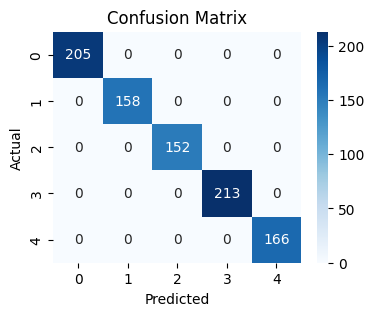

In [95]:
cm = confusion_matrix(y_train, yhat_train)

# Plot confusion matrix using seaborn
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [96]:
# Predict labels on the training and test sets
tfSuper_test = tfidfvec_supervised.transform(X_test)
yhat_test = svm_clf.predict(tfSuper_test)

In [97]:
#create a submission dataframe
test_predictions = pd.DataFrame(columns=['ArticleId', 'Category', 'yhat'])
test_predictions['ArticleId'] = test['ArticleId']
# test_predictions['yhat'] = yhat_test
test_predictions['Category'] =yhat_test

#delete columns unneeded for submission
test_predictions = test_predictions.drop('yhat', 1)
print(test_predictions.head(2))

   ArticleId Category
0       1018    sport
1       1319     tech


<ipython-input-97-4d4669551c78>:8: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  test_predictions = test_predictions.drop('yhat', 1)


In [98]:
#save and submit test dataframe
try:
    test_predictions.to_csv('svc_submission.csv', index=False)
except:
    pass

# kaggle test score was 0.97278

In [99]:
!kaggle competitions submit -c learn-ai-bbc -f svc_submission.csv -m "SVC model"

100% 9.22k/9.22k [00:00<00:00, 36.6kB/s]
Successfully submitted to BBC News Classification

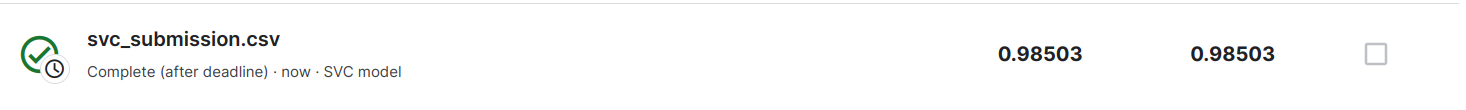

In [100]:
svc_img=Image.open('./Kaggle_Completion_Score/svc.png',)
svc_img

SVC of supervisied model achieved the highest test score over all the trained model including NMF unsupervised model.